In [ ]:
!pip install keras_vggface

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras.engine import  Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras import optimizers
from keras_vggface.vggface import VGGFace
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [ ]:
print(tf.__version__)
print(keras.__version__)

1.15.2
2.3.1


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [2]:
# data are in dataset folder in zipped format
!ls "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/"

fer2013.csv  PrivateTest.zip  PublicTest.zip  Training.zip


In [12]:
!ls ../content/

drive  sample_data


In [13]:
# This creates a temporary folder in drive root folder, so it will have to be reloaded again when required after terminating the session
# Permanent data are stored in dataset in zipped format
# This copies the zipped file and store in root of google drive temporarily
! rm -rf Training; mkdir Training
! unzip -q "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/Training.zip" -d Training

! rm -rf Validation; mkdir Validation
! unzip -q "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/PublicTest.zip" -d Validation

! rm -rf Test; mkdir Test
! unzip -q "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/PrivateTest.zip" -d Test

In [14]:
!ls

drive  sample_data  Test  Training  Validation


In [ ]:
!ls -l Training/

total 804
drwxr-xr-x 2 root root 122880 Oct 11 05:04 Angry
drwxr-xr-x 2 root root  16384 Oct 11 05:04 Disgust
drwxr-xr-x 2 root root 118784 Oct 11 05:04 Fear
drwxr-xr-x 2 root root 208896 Oct 11 05:04 Happy
drwxr-xr-x 2 root root 135168 Oct 11 05:04 Neutral
drwxr-xr-x 2 root root 131072 Oct 11 05:04 Sad
drwxr-xr-x 2 root root  90112 Oct 11 05:04 Surprise


In [ ]:
%%bash
root='Training/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

Angry: 3995
Disgust: 436
Fear: 4097
Happy: 7215
Neutral: 4965
Sad: 4830
Surprise: 3171


In [ ]:
%%bash
root='Validation/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

Angry: 467
Disgust: 56
Fear: 496
Happy: 895
Neutral: 607
Sad: 653
Surprise: 415


In [ ]:
%%bash
root='Test/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

Angry: 491
Disgust: 55
Fear: 528
Happy: 879
Neutral: 626
Sad: 594
Surprise: 416


In [ ]:
train_dir = "Training/"
validation_dir = "Validation/"
test_dir = "Test/"

## All data are ready

In [ ]:
# Setting image height and width
img_height = 224
img_width = 224

In [ ]:
# https://github.com/rcmalli/keras-vggface#projects--blog-posts
conv_base = VGGFace(model='vgg16',
                  include_top = False,
                  input_shape = (img_height, img_width, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58916864/58909280 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

In [ ]:
print("Number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("Number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

Number of trainable weights before freezing the conv base: 26
Number of trainable weights after freezing the conv base: 0


In [ ]:
conv_base.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

In [ ]:
DROP_OUT_RATE = 0.5

last_layer = conv_base.output

# x = Flatten(name='flatten')(last_layer)
x = GlobalAveragePooling2D(name="global_average_pool_1")(last_layer)
x = Dropout(DROP_OUT_RATE)(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(DROP_OUT_RATE)(x)
x = Dense(512, activation='relu', name='fc2')(x)
out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(conv_base.input, out)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [ ]:
set_trainable = False
for layer in model.layers:
  if layer.name == "global_average_pool_1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [ ]:
# Image Data Generator setup
train_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True
                                   )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height,img_width),
    batch_size = 50,
    shuffle = True,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (img_height,img_width),
    batch_size = 50,
    class_mode = 'categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height,img_width),
    batch_size = 50,
    class_mode = 'categorical'
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}


In [ ]:
def class_weight_computer():
  """
    Training Data categories and number of samples in them
    Angry: 3995
    Disgust: 436
    Fear: 4097
    Happy: 7215
    Neutral: 4965
    Sad: 4830
    Surprise: 3171
  """
  samples_per_label = [3995, 436, 4097, 7215, 4965, 4830, 3171]
  total_samples = sum(samples_per_label)
  return dict([(i, total_samples/(7*j)) for (i,j) in enumerate(samples_per_label)]) # https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
class_weight_computer()

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8260394187886635,
 5: 0.8491274770777877,
 6: 1.293372978330405}

In [ ]:
class_weights = class_weight_computer()
print(class_weights)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
EPOCHS = 30
history = model.fit_generator(
    train_generator,
    steps_per_epoch=28709//50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=3589//50,
    shuffle=True,
    class_weight=class_weights,
    callbacks=[reduce_lr]
)


Epoch 1/30
574/574 [==============================] - 364s 633ms/step - loss: 1.6781 - accuracy: 0.3423 - val_loss: 1.4864 - val_accuracy: 0.4738
Epoch 2/30
574/574 [==============================] - 359s 625ms/step - loss: 1.5450 - accuracy: 0.4099 - val_loss: 1.2091 - val_accuracy: 0.5236
Epoch 3/30
574/574 [==============================] - 355s 619ms/step - loss: 1.5069 - accuracy: 0.4192 - val_loss: 1.1704 - val_accuracy: 0.4922
Epoch 4/30
574/574 [==============================] - 354s 616ms/step - loss: 1.5098 - accuracy: 0.4226 - val_loss: 1.4292 - val_accuracy: 0.5064
Epoch 5/30
574/574 [==============================] - 355s 619ms/step - loss: 1.4878 - accuracy: 0.4297 - val_loss: 1.2888 - val_accuracy: 0.5476
Epoch 6/30
574/574 [==============================] - 347s 605ms/step - loss: 1.4737 - accuracy: 0.4295 - val_loss: 1.0671 - val_accuracy: 0.5264
Epoch 7/30
574/574 [==============================] - 345s 602ms/step - loss: 1.4726 - accuracy: 0.4353 - val_loss: 1.0995 

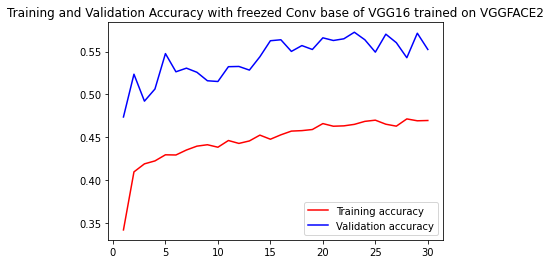

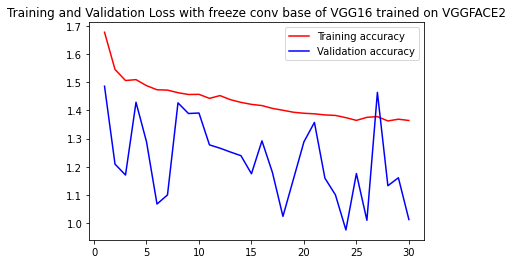

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label="Training accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title('Training and Validation Accuracy with freezed Conv base of VGG16 trained on VGGFACE2')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss with freeze conv base of VGG16 trained on VGGFACE2')
plt.legend()
plt.show()

In [ ]:
print('\nEvaluate on Validation data')
results_validation = model.evaluate_generator(validation_generator, 3589//50 )
print('Validation loss, Validation Accuracy:', results_validation)


Evaluate on Validation data
Validation loss, Validation Accuracy: [1.205168604850769, 0.5495774745941162]


In [ ]:
print('\nEvaluate on test data')
results_test = model.evaluate_generator(test_generator, 3589//50)
print('test loss, test acc:', results_test)


Evaluate on test data
test loss, test acc: [1.1763018369674683, 0.5681689977645874]


In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]

In [ ]:
print(epoch_str)
print(test_acc)

-EPOCHS_30
test_acc_0.568


In [ ]:
# Saving the history contents
history_path = "drive/My Drive/ENGR635-Deep Learning System Design Project/Models/VGG16_VGGFACE/history_VGG16_VGGFACE"+epoch_str + test_acc + ".npy"
np.save(history_path, history.history)

In [ ]:
# Saving the model
model.save("drive/My Drive/ENGR635-Deep Learning System Design Project/Models/VGG16_VGGFACE/" + 'VGG16_VGG_FACE' + epoch_str + test_acc + '.h5')

### Fine Tuning the trained model

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model("drive/My Drive/ENGR635-Deep Learning System Design Project/Models/VGG16_VGGFACE/VGG16_VGG_FACE-EPOCHS_30test_acc_0.568.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [ ]:
print('\nEvaluate on test data')
results_test = model.evaluate_generator(test_generator, 3589//50)
print('test loss, test acc:', results_test)


Evaluate on test data
test loss, test acc: [0.9291700720787048, 0.5701408386230469]


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [ ]:
# Setting all the layers to be trainable
for layer in model.layers:
  layer.trainable = True

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [ ]:
# Choosing last convolutional blocks of VGG16 to be trainable for fine tuning
set_trainable = False
for layer in model.layers:
  if layer.name == "conv5_3":
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [ ]:
EPOCHS = 50
history = model.fit_generator(
    train_generator,
    steps_per_epoch=28709//50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=3589//50,
    shuffle=True,
    class_weight=class_weights,
    callbacks=[reduce_lr]
)

Epoch 1/50
574/574 [==============================] - 351s 612ms/step - loss: 0.8019 - accuracy: 0.6755 - val_loss: 0.7284 - val_accuracy: 0.6772
Epoch 2/50
574/574 [==============================] - 358s 624ms/step - loss: 0.7953 - accuracy: 0.6740 - val_loss: 0.8061 - val_accuracy: 0.6714
Epoch 3/50
574/574 [==============================] - 364s 634ms/step - loss: 0.7909 - accuracy: 0.6762 - val_loss: 0.8981 - val_accuracy: 0.6779
Epoch 4/50
574/574 [==============================] - 363s 633ms/step - loss: 0.7891 - accuracy: 0.6773 - val_loss: 0.7149 - val_accuracy: 0.6702
Epoch 5/50
574/574 [==============================] - 369s 643ms/step - loss: 0.7792 - accuracy: 0.6813 - val_loss: 0.8781 - val_accuracy: 0.6790
Epoch 6/50
574/574 [==============================] - 372s 648ms/step - loss: 0.7793 - accuracy: 0.6774 - val_loss: 1.2316 - val_accuracy: 0.6748
Epoch 7/50
574/574 [==============================] - 372s 649ms/step - loss: 0.7821 - accuracy: 0.6830 - val_loss: 0.9144 -

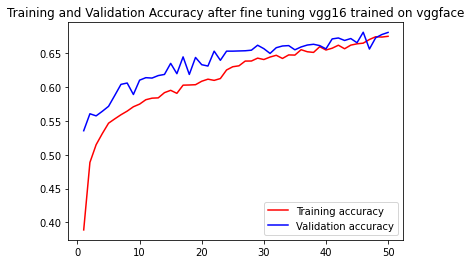

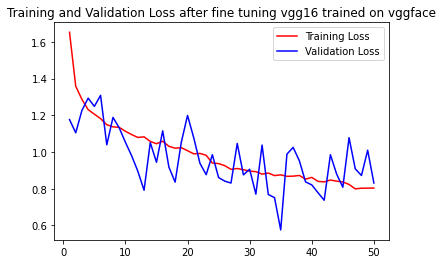

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label="Training accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title('Training and Validation Accuracy after fine tuning vgg16 trained on vggface')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss after fine tuning vgg16 trained on vggface')
plt.legend()
plt.show()

In [ ]:
print('\nEvaluate on test data')
results_test = model.evaluate_generator(test_generator, 3589//50)
print('test loss, test acc:', results_test)


Evaluate on test data
test loss, test acc: [0.6502085328102112, 0.6794366240501404]


In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]

In [ ]:
# Saving the history contents
history_path = "drive/My Drive/ENGR635-Deep Learning System Design Project/Models/VGG16_VGGFACE/history_VGG16_VGGFACE_finetuned"+epoch_str + test_acc + ".npy"
np.save(history_path, history.history)


In [ ]:
# Saving the model
model.save("drive/My Drive/ENGR635-Deep Learning System Design Project/Models/VGG16_VGGFACE/" + 'VGG16_VGG_FACE_finetuned' + epoch_str + test_acc + '.h5')